### Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import download
download("punkt")
download("stopwords")
download("wordnet")


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nabih\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nabih\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nabih\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Reading the data

In [2]:
df = pd.read_csv("dataset/Resume/Resume.csv")
df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


### Data Exploration

For this classification task, we will use the following feature and label:
- `Resume_str` - The resume text (feature)
- `Category` - The category of the resume (label)

And the other two features are not used for this task.

In [3]:
# Dropping the nonessential columns
df.drop(columns=["ID", "Resume_html"], inplace=True)
df.head(5)

,Resume_str,Category
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,HR DIRECTOR Summary Over 2...,HR
3,HR SPECIALIST Summary Dedica...,HR
4,HR MANAGER Skill Highlights ...,HR


In [4]:
# The dataframe has 2484 entries of data for both of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Resume_str  2484 non-null   object
 1   Category    2484 non-null   object
dtypes: object(2)
memory usage: 38.9+ KB


In [5]:
# There are no null values
df.isnull().sum()

Resume_str    0
Category      0
dtype: int64

In [6]:
number_of_category = df["Category"].nunique()
print(f"Number of Categories: {number_of_category}")

Number of Categories: 24


In [7]:
df["Category"].value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

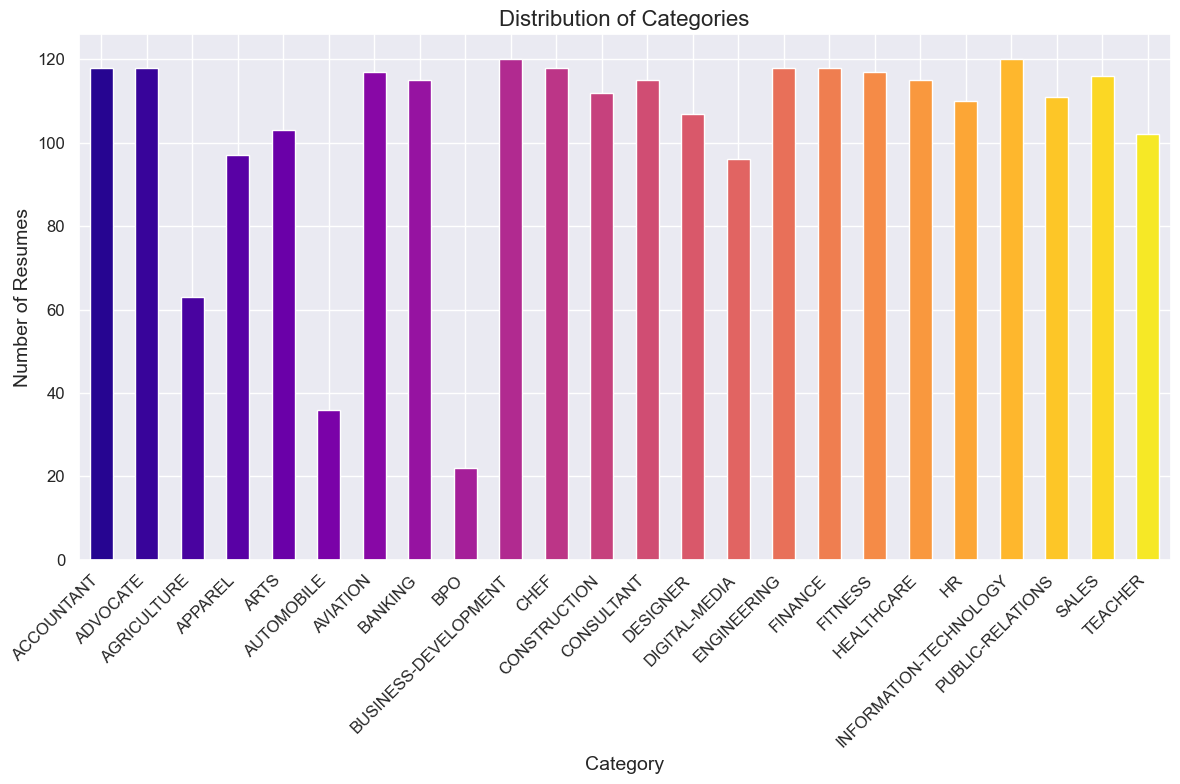

In [8]:
# Bar Graph for the distribution of the "Category" column
sns.set_theme()

df["Category"].value_counts().sort_index().plot(kind="bar", figsize=(12, 8), 
                                                color=sns.color_palette("plasma", 
                                                df["Category"].nunique()))

# Adding title and labels for x-axis and y-axis
plt.title("Distribution of Categories", fontsize=16)
plt.xlabel("Category", fontsize=14)
plt.ylabel("Number of Resumes", fontsize=14)

plt.xticks(rotation=45, ha="right", fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

From the value count of the column "Category" and the graph above we can see that Information-Technology and Business-Development has hightest number of resumes. And, the least number of resumes are for BPO.

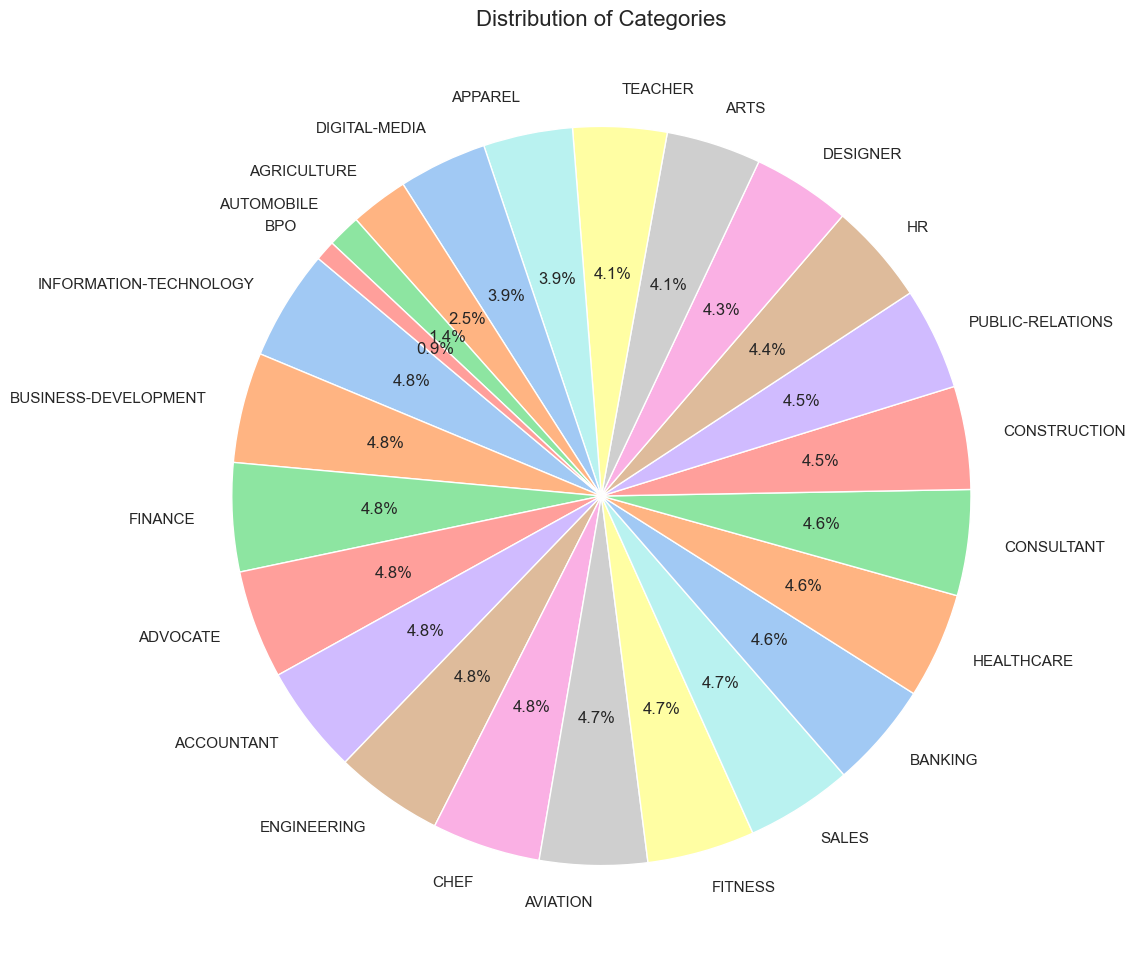

In [9]:
# Pie chart for the distribution of the "Category" column
category_counts = df["Category"].value_counts()

plt.figure(figsize=(12, 12))
plt.pie(category_counts, labels=category_counts.index, autopct="%1.1f%%", startangle=140, 
        colors=sns.color_palette("pastel", len(category_counts)))
plt.title("Distribution of Categories", fontsize=16)
plt.show()

From the above pie chart, we can see that the distribution of data is not uniform. We have less data for the category 'BPO', 'Automobile' and 'Agriculture' than the other categories.

### Data Cleaning and Preprocessing

In [10]:
def resume_cleaning(text):
    # Removing HTML tags 
    cleaned_text = re.sub(r'<.*?>', ' ', text)
    
    # Removing URLs
    cleaned_text = re.sub(r'http\S+', ' ', cleaned_text)
    
    # Removing non-alphabetical characters, punctuation, special characters, digits, continuous underscores, and extra whitespace
    cleaned_text = re.sub('[^a-zA-Z]', ' ', cleaned_text)
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    # Converting to lowercase
    cleaned_text = cleaned_text.lower()
    
    # Tokenizing the cleaned text
    words = word_tokenize(cleaned_text)
    
    # Removing stopwords
    stop_words = set(stopwords.words("english"))
    filtered_words = [word for word in words if word not in stop_words]
    
    # Applying stemming
    stemmer = PorterStemmer()
    stemmed_words = [stemmer.stem(word) for word in filtered_words]
    
    # Applying lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stemmed_words]
    
    # Joining words back into a single string
    cleaned_text = " ".join(lemmatized_words)
    
    return cleaned_text

In [11]:
df["Cleaned_Resume"] = df["Resume_str"].apply(lambda x:resume_cleaning(x))

In [12]:
df.head()

,Resume_str,Category,Cleaned_Resume
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administr market associ hr administr summar...
1,"HR SPECIALIST, US HR OPERATIONS ...",HR,hr specialist u hr oper summari versatil mediu...
2,HR DIRECTOR Summary Over 2...,HR,hr director summari year experi recruit plu ye...
3,HR SPECIALIST Summary Dedica...,HR,hr specialist summari dedic driven dynam year ...
4,HR MANAGER Skill Highlights ...,HR,hr manag skill highlight hr skill hr depart st...


In [13]:
df["Cleaned_Resume"][0]

'hr administr market associ hr administr summari dedic custom servic manag year experi hospit custom servic manag respect builder leader custom focus team strive instil share enthusiast commit custom servic highlight focus custom satisfact team manag market savvi conflict resolut techniqu train develop skill multi tasker client relat specialist accomplish missouri dot supervisor train certif certifi ihg custom loyalti market segment hilton worldwid gener manag train certif accomplish trainer cross server hospit system hilton onq micro opera pm fidelio opera reserv system or holidex complet cours seminar custom servic sale strategi inventori control loss prevent safeti time manag leadership perform ass experi hr administr market associ hr administr dec current compani name citi state help develop polici direct coordin activ employ compens labor relat benefit train employe servic prepar employe separ notic relat document keep record benefit plan particip insur pension plan personnel tran

In [14]:
# Applying Label Encoder to the "Category" Column
encoder = LabelEncoder()
df["Category"]=encoder.fit_transform(df["Category"])

In [15]:
df.head()

,Resume_str,Category,Cleaned_Resume
0,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,19,hr administr market associ hr administr summar...
1,"HR SPECIALIST, US HR OPERATIONS ...",19,hr specialist u hr oper summari versatil mediu...
2,HR DIRECTOR Summary Over 2...,19,hr director summari year experi recruit plu ye...
3,HR SPECIALIST Summary Dedica...,19,hr specialist summari dedic driven dynam year ...
4,HR MANAGER Skill Highlights ...,19,hr manag skill highlight hr skill hr depart st...


### Data Splitting

In [16]:
# Splitting data into training and testing sets (15% test), stratified by 'Category' for balanced distribution.
X_train, X_test, y_train, y_test = train_test_split(df["Cleaned_Resume"], df["Category"], test_size=0.15, 
                                                    random_state=42, stratify=df["Category"])
# Printing the sizes of the split datasets
print("Train data size:", X_train.shape)
print("Test data size:", X_test.shape)

Train data size: (2111,)
Test data size: (373,)


### Vectorization of TF-IDF

In [17]:
# Creating TF-IDF vectors for training and testing data, using 800 features and English stop words.
tfidf = TfidfVectorizer(stop_words = "english", max_features = 5000)
tfidf_train_vectors = tfidf.fit_transform(X_train)
tfidf_test_vectors = tfidf.transform(X_test)
tfidf_train_vectors.shape

(2111, 5000)

### Model

#### Using RandomForestClassifier

In [18]:
# Initializing the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Fitting the model on training data
rf_model.fit(tfidf_train_vectors, y_train)
# Predicting on validation data
prediction_random_forest = rf_model.predict(tfidf_test_vectors)

# Calculating accuracy, precision, recall and F1 score for Random Forest Classifier
accuracy = accuracy_score(y_test, prediction_random_forest)
precision = precision_score(y_test, prediction_random_forest, average="weighted", zero_division=1)
recall = recall_score(y_test, prediction_random_forest, average="weighted")
f1 = f1_score(y_test, prediction_random_forest, average="weighted")

# Print accuracy, precisionm, recall and F1 score for validation data
print(f"Accuracy for Random Forest Classifier: {accuracy * 100:.2f}%")
print(f"Precision for Random Forest Classifier: {precision * 100:.2f}%")
print(f"Recall for Random Forest Classifier: {recall * 100:.2f}%")
print(f"F1 Score for Random Forest Classifier: {f1 * 100:.2f}%")

Accuracy for Random Forest Classifier: 64.34%
Precision for Random Forest Classifier: 66.85%
Recall for Random Forest Classifier: 64.34%
F1 Score for Random Forest Classifier: 62.20%


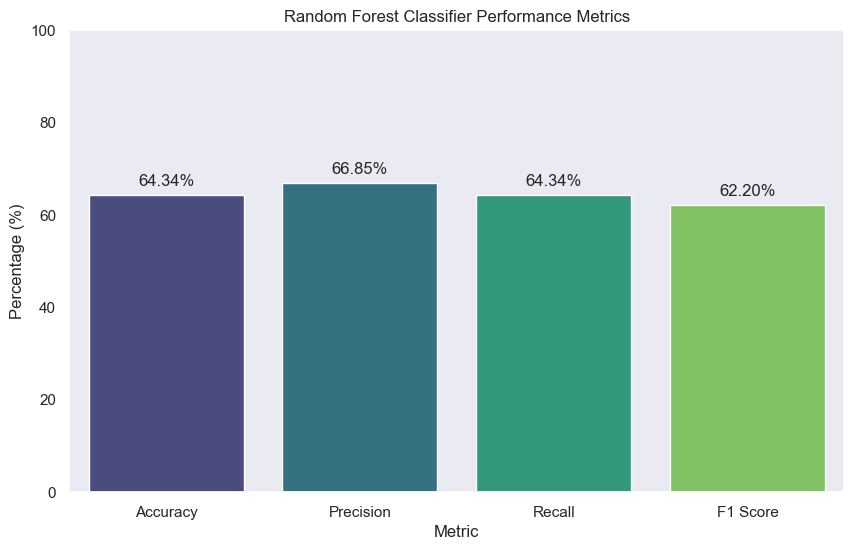

In [19]:
# Metrics for plotting
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [accuracy * 100, precision * 100, recall * 100, f1 * 100]

df_metrics = pd.DataFrame({
    "Metric": metrics,
    "Value": values
})

# Creating a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Value", data=df_metrics, palette="viridis")

# Setting the limits and title
plt.ylim(0, 100)
plt.title("Random Forest Classifier Performance Metrics")
plt.ylabel("Percentage (%)")
plt.grid(axis="y")

# Displaying the values on top of the bars
for index, value in enumerate(values):
    plt.text(index, value + 2, f"{value:.2f}%", ha="center")

plt.show()

#### Using Logistic Regression

In [20]:
# Initializing the Logistic Regression
lr_model = LogisticRegression(C=1, max_iter=1000, penalty="l1", solver="saga", random_state=42)

# Fitting the model on training data
lr_model.fit(tfidf_train_vectors, y_train)

# Predict on validation data
prediction_lr = lr_model.predict(tfidf_test_vectors)

# Calculating accuracy, precision, recall and F1 score for Logistic Regression
accuracy = accuracy_score(y_test, prediction_lr)
precision = precision_score(y_test, prediction_lr, average="weighted", zero_division=1)
recall = recall_score(y_test, prediction_lr, average="weighted")
f1 = f1_score(y_test, prediction_lr, average="weighted")

# Print accuracy, precisionm, recall and F1 score for validation data
print(f"Accuracy for Logistic Regression: {accuracy * 100:.2f}%")
print(f"Precision for Logistic Regression: {precision * 100:.2f}%")
print(f"Recall for Logistic Regression: {recall * 100:.2f}%")
print(f"F1 Score for Logistic Regression: {f1 * 100:.2f}%")

Accuracy for Logistic Regression: 68.36%
Precision for Logistic Regression: 69.41%
Recall for Logistic Regression: 68.36%
F1 Score for Logistic Regression: 67.76%


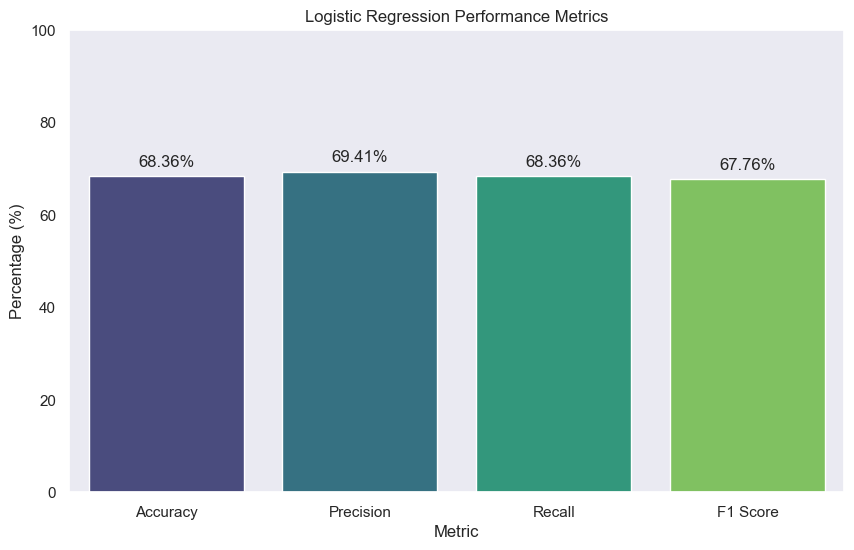

In [21]:
# Metrics for plotting
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [accuracy * 100, precision * 100, recall * 100, f1 * 100]

df_metrics = pd.DataFrame({
    "Metric": metrics,
    "Value": values
})

# Creating a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Value", data=df_metrics, palette="viridis")

# Setting the limits and title
plt.ylim(0, 100)
plt.title("Logistic Regression Performance Metrics")
plt.ylabel("Percentage (%)")
plt.grid(axis="y")

# Displaying the values on top of the bars
for index, value in enumerate(values):
    plt.text(index, value + 2, f"{value:.2f}%", ha="center")

plt.show()

#### Using Light GBM Classifier

In [22]:
# Initializing the Light GBM Classifier
light_bgm_model = LGBMClassifier(verbose=-1, random_state=42)

# Fitting the model on training data
light_bgm_model.fit(tfidf_train_vectors, y_train)

# Predict on validation data
prediction_light_bgm = light_bgm_model.predict(tfidf_test_vectors)

# Calculating accuracy, precisionm, recall and F1 score for Light GBM Classifier
accuracy = accuracy_score(y_test, prediction_light_bgm)
precision = precision_score(y_test, prediction_light_bgm, average="weighted")
recall = recall_score(y_test, prediction_light_bgm, average="weighted")
f1 = f1_score(y_test, prediction_light_bgm, average="weighted")

# Print accuracy, precisionm, recall and F1 score for validation data
print(f"Accuracy for Light GBM Classifier: {accuracy * 100:.2f}%")
print(f"Precision for Light GBM Classifier: {precision * 100:.2f}%")
print(f"Recall for Light GBM Classifier: {recall * 100:.2f}%")
print(f"F1 for Light GBM Classifier: {f1 * 100:.2f}%")

Accuracy for Light GBM Classifier: 69.97%
Precision for Light GBM Classifier: 71.25%
Recall for Light GBM Classifier: 69.97%
F1 for Light GBM Classifier: 69.06%


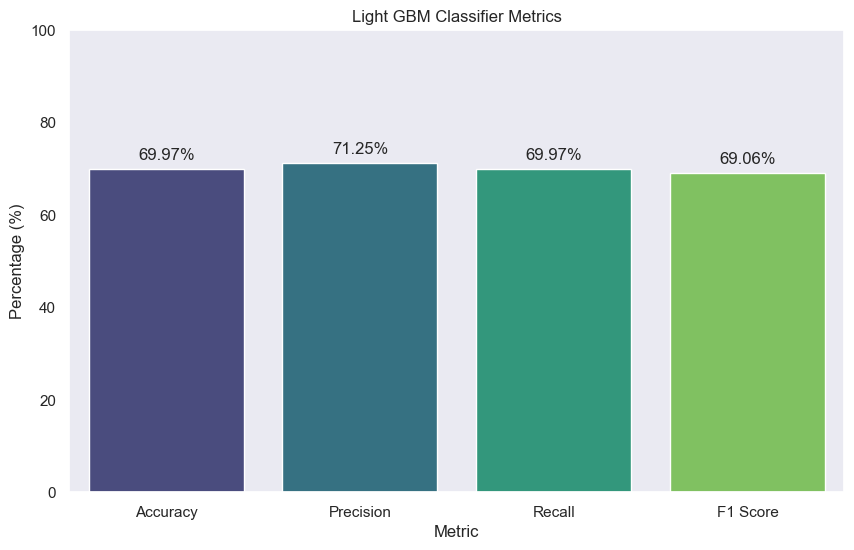

In [23]:
# Metrics for plotting
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [accuracy * 100, precision * 100, recall * 100, f1 * 100]

df_metrics = pd.DataFrame({
    "Metric": metrics,
    "Value": values
})

# Creating a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Value", data=df_metrics, palette="viridis")

# Setting the limits and title
plt.ylim(0, 100)
plt.title("Light GBM Classifier Metrics")
plt.ylabel("Percentage (%)")
plt.grid(axis="y")

# Displaying the values on top of the bars
for index, value in enumerate(values):
    plt.text(index, value + 2, f"{value:.2f}%", ha="center")

plt.show()

#### Using XGBoost classifier

In [24]:
# Initializing the XGBoost classifier
xgboost_model = XGBClassifier(eval_metric='mlogloss', random_state=42)

# Fitting the model on training data
xgboost_model.fit(tfidf_train_vectors, y_train)

# Predicting on validation data
prediction_xgboost = xgboost_model.predict(tfidf_test_vectors)

# Calculating accuracy, precision, recall, and F1 score for XGBoost Classifier
accuracy = accuracy_score(y_test, prediction_xgboost)
precision = precision_score(y_test, prediction_xgboost, average='weighted', zero_division=1)
recall = recall_score(y_test, prediction_xgboost, average='weighted')
f1 = f1_score(y_test, prediction_xgboost, average='weighted')

# Print accuracy, precision, recall, and F1 score for validation data
print(f"Accuracy for XGBoost Classifier: {accuracy * 100:.2f}%")
print(f"Precision for XGBoost Classifier: {precision * 100:.2f}%")
print(f"Recall for XGBoost Classifier: {recall * 100:.2f}%")
print(f"F1 Score for XGBoost Classifier: {f1 * 100:.2f}%")

Accuracy for XGBoost Classifier: 69.44%
Precision for XGBoost Classifier: 70.64%
Recall for XGBoost Classifier: 69.44%
F1 Score for XGBoost Classifier: 68.49%


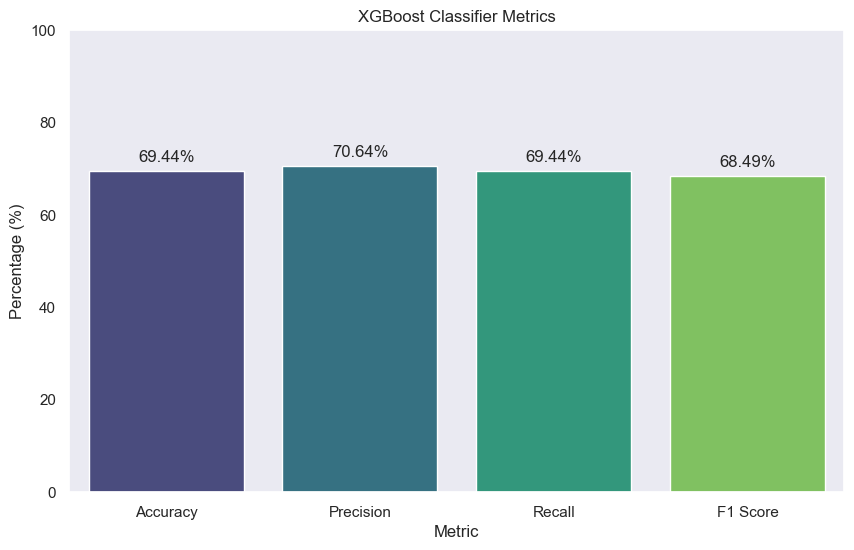

In [25]:
# Metrics for plotting
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [accuracy * 100, precision * 100, recall * 100, f1 * 100]

df_metrics = pd.DataFrame({
    "Metric": metrics,
    "Value": values
})

# Creating a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Value", data=df_metrics, palette="viridis")

# Setting the limits and title
plt.ylim(0, 100)
plt.title("XGBoost Classifier Metrics")
plt.ylabel("Percentage (%)")
plt.grid(axis="y")

# Displaying the values on top of the bars
for index, value in enumerate(values):
    plt.text(index, value + 2, f"{value:.2f}%", ha="center")

plt.show()

Four different models are used to classify the resumes. The models are:
1. Random Forest Classifier
2. Logistic Regression
3. Light GBM Classifier
4. XGBoost Classifier

Among these four models, Light GBM Classifiern is the best model for the dataset. The following metrics are used to evaluate the models:
1. Test Accuracy
2. Precision
3. Recall
4. F1 Score

### Saving the model

In [26]:
joblib.dump(light_bgm_model, "model/light_bgm_model.pkl")
joblib.dump(tfidf, "model/vectorizer.pkl")
joblib.dump(encoder, "model/label_encoder.pkl")

['model/label_encoder.pkl']